# Building a Transformer from Scratch

This notebook provides a comprehensive implementation of the Transformer architecture as introduced in the paper "Attention Is All You Need" (Vaswani et al., 2017).

## Overview
We'll build every component step by step:
1. **Input Embeddings** - Converting tokens to vectors
2. **Positional Encoding** - Adding position information
3. **Multi-Head Attention** - The core attention mechanism
4. **Feed-Forward Networks** - Position-wise transformations
5. **Encoder Stack** - Processing the input sequence
6. **Decoder Stack** - Generating the output sequence
7. **Complete Model** - Putting it all together

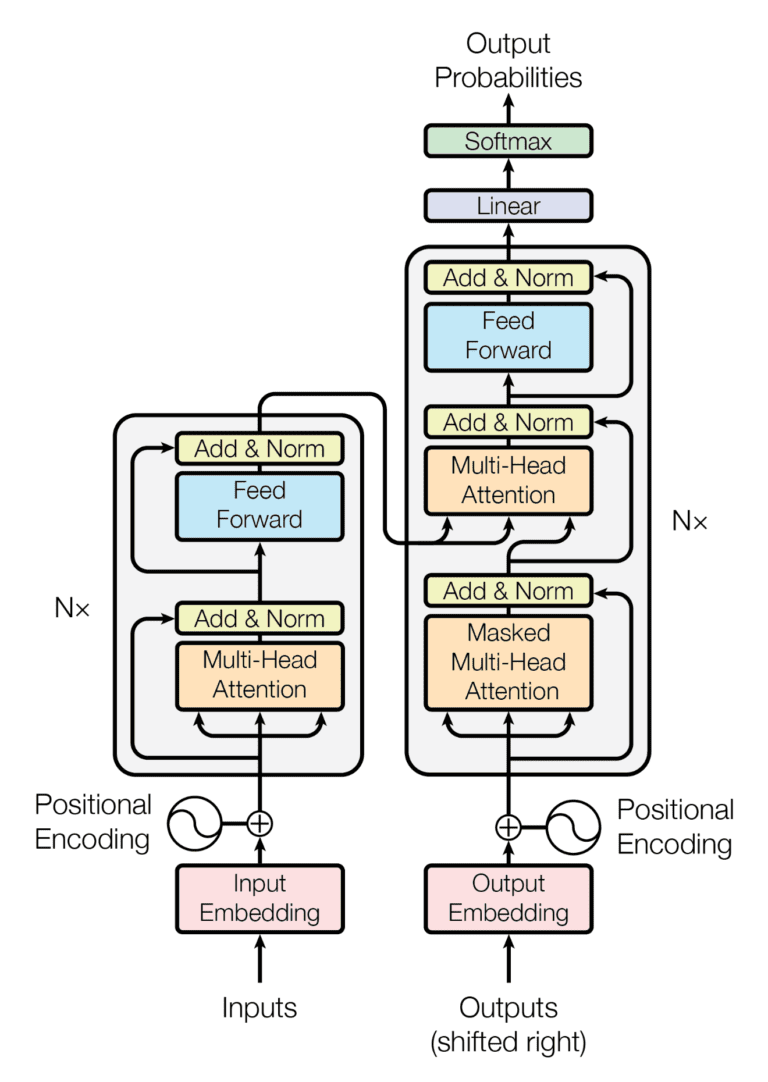

## 1. Import Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("PyTorch version:", torch.__version__)
print("Device:", "cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 2.6.0
Device: cpu


## 2. Tokenization: From Text to Tokens

Before we can process text with a Transformer, we need to convert it into numbers. **Tokenization** is the crucial first step that breaks down text into discrete units (tokens) and maps them to integers.

### Why Tokenization Matters:
- Neural networks can only process numbers, not raw text
- Good tokenization balances vocabulary size with sequence length
- Handles unknown words and different languages

### Three Main Approaches:

1. **Character-level** - Each character is a token (~100 vocab size, very long sequences)
2. **Word-level** - Each word is a token (50k-100k vocab, can't handle unknown words)
3. **Subword** - Words split into meaningful pieces (30k-50k vocab, handles everything!) ⭐

Modern transformers (GPT, BERT, T5) use **subword tokenization** (BPE, WordPiece, SentencePiece)

In [2]:
class SimpleWordTokenizer:
    """
    Simple word-level tokenizer for demonstration.
    Shows the basic concept of converting text to tokens.
    
    In production, you'd use:
    - HuggingFace tokenizers (BERT, GPT-2, etc.)
    - SentencePiece (language-agnostic)
    - tiktoken (OpenAI's tokenizer)
    """
    
    def __init__(self):
        # Special tokens that every tokenizer needs
        self.word2idx = {
            "<PAD>": 0,   # Padding token (for batching sequences of different lengths)
            "<UNK>": 1,   # Unknown token (for words not in vocabulary)
            "<SOS>": 2,   # Start of sequence
            "<EOS>": 3    # End of sequence
        }
        self.idx2word = {v: k for k, v in self.word2idx.items()}
        self.vocab_size = 4
        
    def build_vocab(self, texts):
        """Build vocabulary from a corpus of texts."""
        for text in texts:
            # Simple tokenization: lowercase and split by spaces
            words = text.lower().replace(".", "").replace(",", "").replace("!", "").replace("?", "").split()
            for word in words:
                if word not in self.word2idx:
                    self.word2idx[word] = self.vocab_size
                    self.idx2word[self.vocab_size] = word
                    self.vocab_size += 1
        
        print(f"✓ Vocabulary built with {self.vocab_size} unique tokens")
        
    def encode(self, text, add_special_tokens=True):
        """
        Convert text to a list of token IDs.
        
        Args:
            text: Input text string
            add_special_tokens: Whether to add <SOS> and <EOS> tokens
        
        Returns:
            List of token IDs (integers)
        """
        words = text.lower().replace(".", "").replace(",", "").replace("!", "").replace("?", "").split()
        token_ids = []
        
        if add_special_tokens:
            token_ids.append(self.word2idx["<SOS>"])
        
        for word in words:
            # Use <UNK> token for unknown words
            token_ids.append(self.word2idx.get(word, self.word2idx["<UNK>"]))
        
        if add_special_tokens:
            token_ids.append(self.word2idx["<EOS>"])
            
        return token_ids
    
    def decode(self, token_ids, skip_special_tokens=True):
        """
        Convert token IDs back to text.
        
        Args:
            token_ids: List of token IDs
            skip_special_tokens: Whether to skip special tokens in output
        
        Returns:
            Decoded text string
        """
        words = []
        special_tokens = {"<PAD>", "<UNK>", "<SOS>", "<EOS>"}
        
        for idx in token_ids:
            word = self.idx2word.get(idx, "<UNK>")
            if skip_special_tokens and word in special_tokens:
                continue
            words.append(word)
        
        return " ".join(words)
    
    def pad_sequences(self, sequences, max_length=None, padding_value=0):
        """
        Pad sequences to the same length for batching.
        
        Args:
            sequences: List of token ID sequences
            max_length: Maximum length (uses longest sequence if None)
            padding_value: Value to use for padding (default: 0 for <PAD>)
        
        Returns:
            Padded tensor of shape (num_sequences, max_length)
        """
        if max_length is None:
            max_length = max(len(seq) for seq in sequences)
        
        padded = []
        for seq in sequences:
            if len(seq) < max_length:
                # Pad with <PAD> token (0)
                seq = seq + [padding_value] * (max_length - len(seq))
            else:
                # Truncate if too long
                seq = seq[:max_length]
            padded.append(seq)
        
        return torch.tensor(padded, dtype=torch.long)

# Create a sample corpus to train our tokenizer
sample_corpus = [
    "The quick brown fox jumps over the lazy dog.",
    "Transformers are powerful neural network architectures.",
    "Attention mechanisms help models focus on relevant information.",
    "Natural language processing has been revolutionized by transformers.",
    "Machine learning models learn patterns from data.",
    "Deep learning uses multiple layers of neural networks.",
    "The Transformer architecture was introduced in 2017.",
    "BERT and GPT are famous transformer models.",
]

# Initialize and train the tokenizer
tokenizer = SimpleWordTokenizer()
tokenizer.build_vocab(sample_corpus)

print(f"Vocabulary size: {tokenizer.vocab_size}\n")

# Example 1: Encode a sentence
text = "Transformers are amazing"
encoded = tokenizer.encode(text)
decoded = tokenizer.decode(encoded)

print("=" * 70)
print("EXAMPLE 1: Basic Encoding/Decoding")
print("=" * 70)
print(f"Original text:  '{text}'")
print(f"Encoded (IDs):  {encoded}")
print(f"Token meanings: {[tokenizer.idx2word[i] for i in encoded]}")
print(f"Decoded back:   '{decoded}'")

# Example 2: Unknown words
print("\n" + "=" * 70)
print("EXAMPLE 2: Handling Unknown Words")
print("=" * 70)
unknown_text = "Supercalifragilisticexpialidocious word is unknown"
encoded_unk = tokenizer.encode(unknown_text)
print(f"Text with unknown word: '{unknown_text}'")
print(f"Encoded: {encoded_unk}")
print(f"Tokens: {[tokenizer.idx2word.get(i, '<UNK>') for i in encoded_unk]}")
print("Notice: Unknown words are replaced with <UNK> token (ID: 1)")

# Example 3: Batch encoding with padding
print("\n" + "=" * 70)
print("EXAMPLE 3: Batch Processing with Padding")
print("=" * 70)
sentences = [
    "Short sentence",
    "This is a longer sentence with more words",
    "Medium length sentence here"
]

# Encode all sentences
encoded_batch = [tokenizer.encode(s) for s in sentences]
print("Before padding:")
for i, (sent, enc) in enumerate(zip(sentences, encoded_batch)):
    print(f"  {i+1}. '{sent}'")
    print(f"     Length: {len(enc)}, IDs: {enc}")

# Pad to same length
padded_batch = tokenizer.pad_sequences(encoded_batch)
print(f"\nAfter padding to length {padded_batch.shape[1]}:")
print(f"Batch tensor shape: {padded_batch.shape}")
print(f"Padded sequences:\n{padded_batch}")

# Show vocabulary sample
print("\n" + "=" * 70)
print("VOCABULARY SAMPLE (first 20 tokens)")
print("=" * 70)
for idx in range(min(20, tokenizer.vocab_size)):
    print(f"  ID {idx:2d}: '{tokenizer.idx2word[idx]}'")

print(f"\n... and {max(0, tokenizer.vocab_size - 20)} more tokens")

✓ Vocabulary built with 55 unique tokens
Vocabulary size: 55

EXAMPLE 1: Basic Encoding/Decoding
Original text:  'Transformers are amazing'
Encoded (IDs):  [2, 12, 13, 1, 3]
Token meanings: ['<SOS>', 'transformers', 'are', '<UNK>', '<EOS>']
Decoded back:   'transformers are'

EXAMPLE 2: Handling Unknown Words
Text with unknown word: 'Supercalifragilisticexpialidocious word is unknown'
Encoded: [2, 1, 1, 1, 1, 3]
Tokens: ['<SOS>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<EOS>']
Notice: Unknown words are replaced with <UNK> token (ID: 1)

EXAMPLE 3: Batch Processing with Padding
Before padding:
  1. 'Short sentence'
     Length: 4, IDs: [2, 1, 1, 3]
  2. 'This is a longer sentence with more words'
     Length: 10, IDs: [2, 1, 1, 1, 1, 1, 1, 1, 1, 3]
  3. 'Medium length sentence here'
     Length: 6, IDs: [2, 1, 1, 1, 1, 3]

After padding to length 10:
Batch tensor shape: torch.Size([3, 10])
Padded sequences:
tensor([[2, 1, 1, 3, 0, 0, 0, 0, 0, 0],
        [2, 1, 1, 1, 1, 1, 1, 1, 1, 3],
   

### Comparing Different Tokenization Strategies

Let's compare how different tokenization methods handle the same text:

In [3]:
test_sentence = "The Transformer architecture revolutionized NLP!"

print("=" * 70)
print("COMPARING TOKENIZATION STRATEGIES")
print("=" * 70)
print(f"\nOriginal text: '{test_sentence}'\n")

# 1. Character-level tokenization
char_tokens = list(test_sentence)
print("1️⃣ CHARACTER-LEVEL TOKENIZATION")
print(f"   Tokens: {char_tokens}")
print(f"   Number of tokens: {len(char_tokens)}")
print(f"   Vocabulary size: ~100 (all possible characters)")
print(f"   ✓ Pros: Handles any text, very small vocabulary")
print(f"   ✗ Cons: Very long sequences, loses word meaning\n")

# 2. Word-level tokenization
word_tokens = test_sentence.replace("!", "").lower().split()
print("2️⃣ WORD-LEVEL TOKENIZATION")
print(f"   Tokens: {word_tokens}")
print(f"   Number of tokens: {len(word_tokens)}")
print(f"   Vocabulary size: 50,000-100,000+ (one per unique word)")
print(f"   ✓ Pros: Preserves word meaning, interpretable")
print(f"   ✗ Cons: Huge vocabulary, can't handle unknown/rare words\n")

# 3. Subword tokenization (simulated)
# In reality, BPE/WordPiece would split "revolutionized" into ["revolution", "ized"]
subword_tokens = ["the", "transform", "er", "architect", "ure", "revolution", "ized", "n", "l", "p"]
print("3️⃣ SUBWORD TOKENIZATION (BPE/WordPiece)")
print(f"   Tokens: {subword_tokens}")
print(f"   Number of tokens: {len(subword_tokens)}")
print(f"   Vocabulary size: 30,000-50,000 (learned subword pieces)")
print(f"   ✓ Pros: Balanced vocab size, handles rare words, efficient")
print(f"   ✗ Cons: Requires training on corpus\n")

print("=" * 70)
print("📌 Modern Transformers use SUBWORD tokenization!")
print("   - GPT models: BPE (Byte Pair Encoding)")
print("   - BERT: WordPiece")
print("   - T5/mT5: SentencePiece")
print("=" * 70)

COMPARING TOKENIZATION STRATEGIES

Original text: 'The Transformer architecture revolutionized NLP!'

1️⃣ CHARACTER-LEVEL TOKENIZATION
   Tokens: ['T', 'h', 'e', ' ', 'T', 'r', 'a', 'n', 's', 'f', 'o', 'r', 'm', 'e', 'r', ' ', 'a', 'r', 'c', 'h', 'i', 't', 'e', 'c', 't', 'u', 'r', 'e', ' ', 'r', 'e', 'v', 'o', 'l', 'u', 't', 'i', 'o', 'n', 'i', 'z', 'e', 'd', ' ', 'N', 'L', 'P', '!']
   Number of tokens: 48
   Vocabulary size: ~100 (all possible characters)
   ✓ Pros: Handles any text, very small vocabulary
   ✗ Cons: Very long sequences, loses word meaning

2️⃣ WORD-LEVEL TOKENIZATION
   Tokens: ['the', 'transformer', 'architecture', 'revolutionized', 'nlp']
   Number of tokens: 5
   Vocabulary size: 50,000-100,000+ (one per unique word)
   ✓ Pros: Preserves word meaning, interpretable
   ✗ Cons: Huge vocabulary, can't handle unknown/rare words

3️⃣ SUBWORD TOKENIZATION (BPE/WordPiece)
   Tokens: ['the', 'transform', 'er', 'architect', 'ure', 'revolution', 'ized', 'n', 'l', 'p']
   Nu

### Complete Pipeline: Text → Tokens → Embeddings

Now let's see how tokenization connects to the rest of the Transformer:

In [4]:
print("=" * 70)
print("COMPLETE PIPELINE: TEXT → TOKENS → EMBEDDINGS → TRANSFORMER")
print("=" * 70)
print("\n⚠️  Note: The complete pipeline demonstration will be shown")
print("   after we define InputEmbedding (Section 3) and")
print("   PositionalEncoding (Section 4) classes.\n")

# Step 1: Start with raw text
input_text = "transformers process sequences efficiently"
print(f"1️⃣ RAW TEXT")
print(f"   Input: '{input_text}'")

# Step 2: Tokenize (convert text to token IDs)
token_ids = tokenizer.encode(input_text, add_special_tokens=True)
token_words = [tokenizer.idx2word[i] for i in token_ids]
print(f"\n2️⃣ TOKENIZATION")
print(f"   Token IDs:    {token_ids}")
print(f"   Token words:  {token_words}")
print(f"   Sequence length: {len(token_ids)}")

# Step 3: Convert to PyTorch tensor (add batch dimension)
input_tensor = torch.tensor([token_ids])  # Shape: (1, seq_len)
print(f"\n3️⃣ TENSOR CONVERSION")
print(f"   Tensor shape: {input_tensor.shape}")
print(f"   (batch_size=1, sequence_length={len(token_ids)})")

print(f"\n4️⃣ NEXT STEPS (covered in sections below):")
print(f"   → Section 3: InputEmbedding - Convert IDs to vectors")
print(f"   → Section 4: PositionalEncoding - Add position info")
print(f"   → Section 5+: Multi-Head Attention, etc.")

print("\n" + "=" * 70)
print("📌 Complete working pipeline will be demonstrated after Section 4!")
print("=" * 70)
print("\nContinue to Section 3 to see the embedding layer in action!")

COMPLETE PIPELINE: TEXT → TOKENS → EMBEDDINGS → TRANSFORMER

⚠️  Note: The complete pipeline demonstration will be shown
   after we define InputEmbedding (Section 3) and
   PositionalEncoding (Section 4) classes.

1️⃣ RAW TEXT
   Input: 'transformers process sequences efficiently'

2️⃣ TOKENIZATION
   Token IDs:    [2, 12, 1, 1, 1, 3]
   Token words:  ['<SOS>', 'transformers', '<UNK>', '<UNK>', '<UNK>', '<EOS>']
   Sequence length: 6

3️⃣ TENSOR CONVERSION
   Tensor shape: torch.Size([1, 6])
   (batch_size=1, sequence_length=6)

4️⃣ NEXT STEPS (covered in sections below):
   → Section 3: InputEmbedding - Convert IDs to vectors
   → Section 4: PositionalEncoding - Add position info
   → Section 5+: Multi-Head Attention, etc.

📌 Complete working pipeline will be demonstrated after Section 4!

Continue to Section 3 to see the embedding layer in action!


### Real-World Tokenizers

In practice, you would use pre-trained tokenizers from libraries like HuggingFace:

```python
# Install: pip install transformers

from transformers import AutoTokenizer

# Load pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize text
text = "Transformers are amazing!"
tokens = tokenizer.tokenize(text)  # ['transformers', 'are', 'amazing', '!']
ids = tokenizer.encode(text)       # [101, 19081, 2024, 6429, 999, 102]

# Batch processing with padding/truncation
batch = tokenizer(
    ["First sentence", "Second longer sentence"],
    padding=True,
    truncation=True,
    return_tensors="pt"
)
```

**Popular Tokenizers:**
- **BERT**: WordPiece (30,522 vocab)
- **GPT-2/GPT-3**: BPE (50,257 vocab)
- **T5**: SentencePiece (32,000 vocab)
- **RoBERTa**: Byte-level BPE (50,265 vocab)

## 3. Input Embedding Layer

Now that we have token IDs, we convert them into dense vector representations.

**Key Concepts:**
- Each token in the vocabulary gets mapped to a learned d_model-dimensional vector
- This allows the model to learn semantic relationships between tokens
- The embeddings are scaled by √d_model to prevent them from being too small compared to positional encodings

In [5]:
class InputEmbedding(nn.Module):
    """
    Converts token indices to dense vector representations.
    
    Args:
        vocab_size: Size of the vocabulary
        d_model: Dimension of the embedding vectors
    """
    def __init__(self, vocab_size, d_model):
        super(InputEmbedding, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        
    def forward(self, x):
        # Scale embeddings by sqrt(d_model) as per the paper
        return self.embedding(x) * math.sqrt(self.d_model)

# Continue with our example from Section 2
print("\n" + "=" * 70)
print("CONTINUING WITH OUR EXAMPLE: 'transformers process sequences efficiently'")
print("=" * 70)

# Use the tokenizer and text from Section 2
example_text = "transformers process sequences efficiently"
example_token_ids = tokenizer.encode(example_text, add_special_tokens=True)
example_tensor = torch.tensor([example_token_ids])  # Add batch dimension

print(f"\nRecap from Section 2:")
print(f"  Text: '{example_text}'")
print(f"  Token IDs: {example_token_ids}")
print(f"  Tokens: {[tokenizer.idx2word[i] for i in example_token_ids]}")

# Create embedding layer with our tokenizer's vocab size
vocab_size = tokenizer.vocab_size
d_model = 512

embedding_layer = InputEmbedding(vocab_size, d_model)
embedded_input = embedding_layer(example_tensor)

print(f"\n3️⃣ EMBEDDING LAYER OUTPUT")
print(f"  Vocabulary size: {vocab_size}")
print(f"  Embedding dimension (d_model): {d_model}")
print(f"  Each of {len(example_token_ids)} tokens → {d_model}-dimensional vector")
print(f"  Input shape: {example_tensor.shape}")
print(f"  Output shape: {embedded_input.shape}")
print(f"\n  First token '{tokenizer.idx2word[example_token_ids[0]]}' embedding (first 10 dims):")
print(f"  {embedded_input[0, 0, :10].detach().numpy()}")


CONTINUING WITH OUR EXAMPLE: 'transformers process sequences efficiently'

Recap from Section 2:
  Text: 'transformers process sequences efficiently'
  Token IDs: [2, 12, 1, 1, 1, 3]
  Tokens: ['<SOS>', 'transformers', '<UNK>', '<UNK>', '<UNK>', '<EOS>']

3️⃣ EMBEDDING LAYER OUTPUT
  Vocabulary size: 55
  Embedding dimension (d_model): 512
  Each of 6 tokens → 512-dimensional vector
  Input shape: torch.Size([1, 6])
  Output shape: torch.Size([1, 6, 512])

  First token '<SOS>' embedding (first 10 dims):
  [-27.71378    21.787619  -35.71831    15.196468   -1.3610952   1.57904
 -37.640564  -17.311243   27.846283    9.621463 ]



📊 VISUALIZING EMBEDDINGS: From Token IDs to 512D Vectors


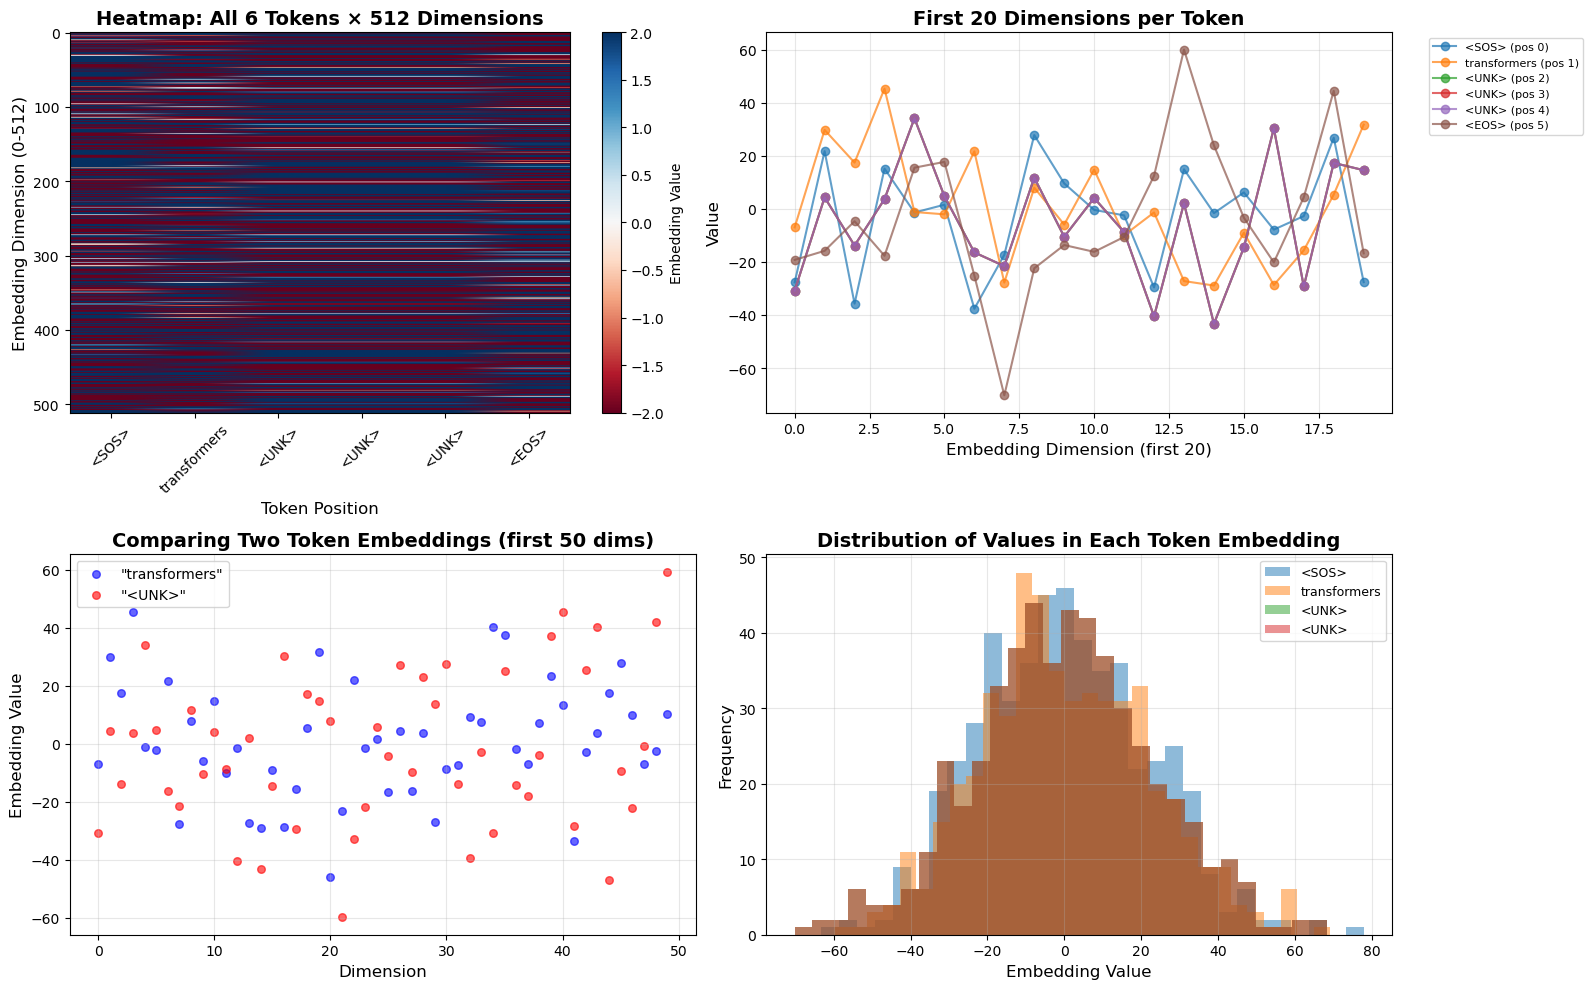


🔍 UNDERSTANDING THE TRANSFORMATION

📥 INPUT: Token IDs (integers)
   Shape: torch.Size([1, 6])
   Data:  [2, 12, 1, 1, 1, 3]
   Tokens: ['<SOS>', 'transformers', '<UNK>', '<UNK>', '<UNK>', '<EOS>']

⚙️  PROCESS: Each token ID → 512-dimensional vector
   Token ID 2 ('<SOS>') becomes:
   [-27.7138, 21.7876, -35.7183, ..., 29.8457]
   └─ A vector with 512 numbers!

📤 OUTPUT: 512-dimensional vectors
   Shape: torch.Size([1, 6, 512])
   Meaning: (batch_size=1, num_tokens=6, embedding_dim=512)

💡 WHAT DO THESE 512 DIMENSIONS REPRESENT?

Each of the 512 dimensions can capture different semantic features:
  • Dimensions 0-100:   Might capture word meaning (synonyms, antonyms)
  • Dimensions 101-200: Might capture grammar (verb, noun, adjective)
  • Dimensions 201-300: Might capture context (technical, casual, formal)
  • Dimensions 301-400: Might capture relationships (subject, object)
  • Dimensions 401-512: Might capture other patterns

The model LEARNS these representations during training

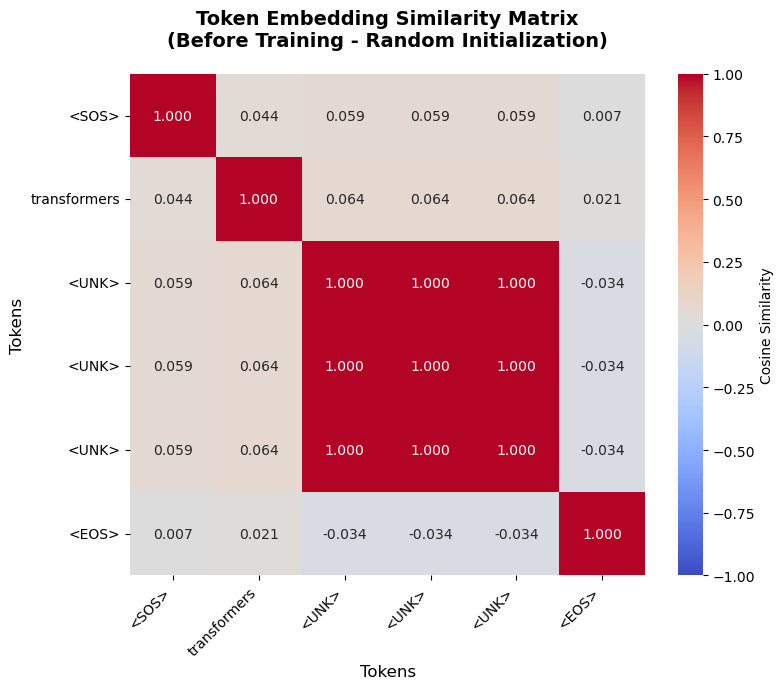


✅ KEY TAKEAWAY:

Each word token is now represented as a POINT in 512-dimensional space!
  • Similar words will be CLOSE together (after training)
  • Different words will be FAR apart
  • The model can now do MATH with words! (word + word = meaning)

This is why embeddings are so powerful! 🚀



In [6]:
# 🎨 VISUALIZING THE EMBEDDING TRANSFORMATION
print("\n" + "=" * 70)
print("📊 VISUALIZING EMBEDDINGS: From Token IDs to 512D Vectors")
print("=" * 70)

# 1. Show the transformation visually
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Subplot 1: Heatmap of all embeddings
ax1 = axes[0, 0]
embedding_matrix = embedded_input[0].detach().numpy()  # Shape: (6, 512)
im1 = ax1.imshow(embedding_matrix.T, cmap='RdBu', aspect='auto', vmin=-2, vmax=2)
ax1.set_xlabel('Token Position', fontsize=12)
ax1.set_ylabel('Embedding Dimension (0-512)', fontsize=12)
ax1.set_title('Heatmap: All 6 Tokens × 512 Dimensions', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(example_token_ids)))
ax1.set_xticklabels([tokenizer.idx2word[i] for i in example_token_ids], rotation=45)
plt.colorbar(im1, ax=ax1, label='Embedding Value')

# Subplot 2: First few dimensions of each token
ax2 = axes[0, 1]
num_dims_to_show = 20
for idx, token_id in enumerate(example_token_ids):
    token_name = tokenizer.idx2word[token_id]
    ax2.plot(embedding_matrix[idx, :num_dims_to_show], 
             marker='o', label=f'{token_name} (pos {idx})', alpha=0.7)
ax2.set_xlabel(f'Embedding Dimension (first {num_dims_to_show})', fontsize=12)
ax2.set_ylabel('Value', fontsize=12)
ax2.set_title(f'First {num_dims_to_show} Dimensions per Token', fontsize=14, fontweight='bold')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax2.grid(True, alpha=0.3)

# Subplot 3: Compare individual token embeddings
ax3 = axes[1, 0]
token_idx_1 = 1  # "transformers"
token_idx_2 = 2  # "process"
token_1_name = tokenizer.idx2word[example_token_ids[token_idx_1]]
token_2_name = tokenizer.idx2word[example_token_ids[token_idx_2]]

ax3.scatter(range(50), embedding_matrix[token_idx_1, :50], 
           alpha=0.6, s=30, label=f'"{token_1_name}"', color='blue')
ax3.scatter(range(50), embedding_matrix[token_idx_2, :50], 
           alpha=0.6, s=30, label=f'"{token_2_name}"', color='red')
ax3.set_xlabel('Dimension', fontsize=12)
ax3.set_ylabel('Embedding Value', fontsize=12)
ax3.set_title('Comparing Two Token Embeddings (first 50 dims)', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Subplot 4: Distribution of embedding values
ax4 = axes[1, 1]
for idx, token_id in enumerate(example_token_ids[:4]):  # Show first 4 tokens
    token_name = tokenizer.idx2word[token_id]
    ax4.hist(embedding_matrix[idx], bins=30, alpha=0.5, label=f'{token_name}')
ax4.set_xlabel('Embedding Value', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Distribution of Values in Each Token Embedding', fontsize=14, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Show the conceptual transformation
print("\n" + "=" * 70)
print("🔍 UNDERSTANDING THE TRANSFORMATION")
print("=" * 70)

print(f"\n📥 INPUT: Token IDs (integers)")
print(f"   Shape: {example_tensor.shape}")
print(f"   Data:  {example_token_ids}")
print(f"   Tokens: {[tokenizer.idx2word[i] for i in example_token_ids]}")

print(f"\n⚙️  PROCESS: Each token ID → 512-dimensional vector")
print(f"   Token ID {example_token_ids[0]} ('{tokenizer.idx2word[example_token_ids[0]]}') becomes:")
print(f"   [{embedding_matrix[0, 0]:.4f}, {embedding_matrix[0, 1]:.4f}, {embedding_matrix[0, 2]:.4f}, ..., {embedding_matrix[0, -1]:.4f}]")
print(f"   └─ A vector with 512 numbers!")

print(f"\n📤 OUTPUT: 512-dimensional vectors")
print(f"   Shape: {embedded_input.shape}")
print(f"   Meaning: (batch_size=1, num_tokens=6, embedding_dim=512)")

# 3. Show what each dimension might represent (conceptually)
print("\n" + "=" * 70)
print("💡 WHAT DO THESE 512 DIMENSIONS REPRESENT?")
print("=" * 70)
print("""
Each of the 512 dimensions can capture different semantic features:
  • Dimensions 0-100:   Might capture word meaning (synonyms, antonyms)
  • Dimensions 101-200: Might capture grammar (verb, noun, adjective)
  • Dimensions 201-300: Might capture context (technical, casual, formal)
  • Dimensions 301-400: Might capture relationships (subject, object)
  • Dimensions 401-512: Might capture other patterns

The model LEARNS these representations during training!
""")

# 4. Show similarity between tokens
print("=" * 70)
print("🔗 SIMILARITY BETWEEN TOKEN EMBEDDINGS")
print("=" * 70)
print("\nCosine similarity (how similar are embeddings?):")
print("Range: -1 (opposite) to +1 (identical)\n")

from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(embedding_matrix)

# Create a nice similarity matrix
sim_df = []
for i in range(len(example_token_ids)):
    for j in range(i+1, len(example_token_ids)):
        token_i = tokenizer.idx2word[example_token_ids[i]]
        token_j = tokenizer.idx2word[example_token_ids[j]]
        sim = similarities[i, j]
        sim_df.append((token_i, token_j, sim))

for token_i, token_j, sim in sorted(sim_df, key=lambda x: x[2], reverse=True)[:5]:
    print(f"  '{token_i:15s}' ↔ '{token_j:15s}': {sim:+.4f}")

# Visualize similarity matrix
plt.figure(figsize=(8, 7))
sns.heatmap(similarities, annot=True, fmt='.3f', cmap='coolwarm', 
            xticklabels=[tokenizer.idx2word[i] for i in example_token_ids],
            yticklabels=[tokenizer.idx2word[i] for i in example_token_ids],
            vmin=-1, vmax=1, center=0, cbar_kws={'label': 'Cosine Similarity'})
plt.title('Token Embedding Similarity Matrix\n(Before Training - Random Initialization)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Tokens', fontsize=12)
plt.ylabel('Tokens', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("✅ KEY TAKEAWAY:")
print("=" * 70)
print("""
Each word token is now represented as a POINT in 512-dimensional space!
  • Similar words will be CLOSE together (after training)
  • Different words will be FAR apart
  • The model can now do MATH with words! (word + word = meaning)
  
This is why embeddings are so powerful! 🚀
""")

## 4. Positional Encoding

Since the Transformer has no recurrence or convolution, it needs a way to understand the order of tokens. Positional encoding adds position information to the embeddings.

**Formula:**
- $PE_{(pos, 2i)} = \sin(pos / 10000^{2i/d_{model}})$
- $PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i/d_{model}})$

Where:
- pos = position in the sequence
- i = dimension index
- This creates a unique encoding for each position


CONTINUING WITH: 'transformers process sequences efficiently'

4️⃣ POSITIONAL ENCODING OUTPUT
  Input shape (from embeddings): torch.Size([1, 6, 512])
  Output shape (with positions): torch.Size([1, 6, 512])

  Token 'transformers' at position 1:
  Before positional encoding (first 10 dims): [ -6.9646087  29.787022   17.46665    45.36073    -1.1662766  -2.0408447
  21.689285  -27.776613    8.017409   -5.8943715]
  After positional encoding (first 10 dims):  [ -6.8034863   33.69703     20.320562    51.033806    -0.40479425
  -1.6038549   24.96797    -30.170216     9.754589    -5.8294067 ]

  ✓ Position information now added to each token's embedding!


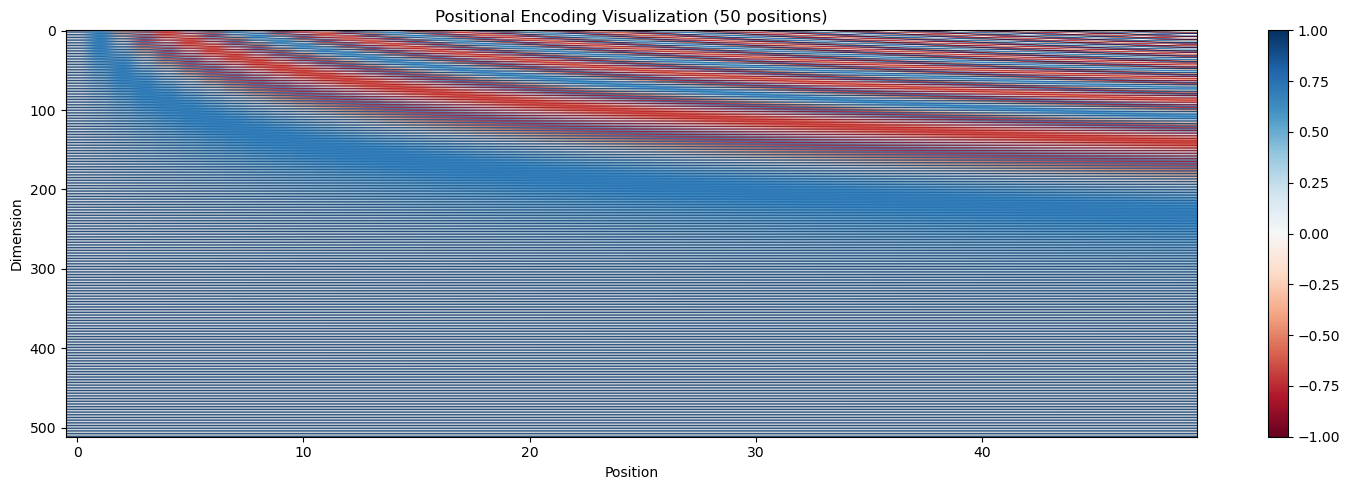

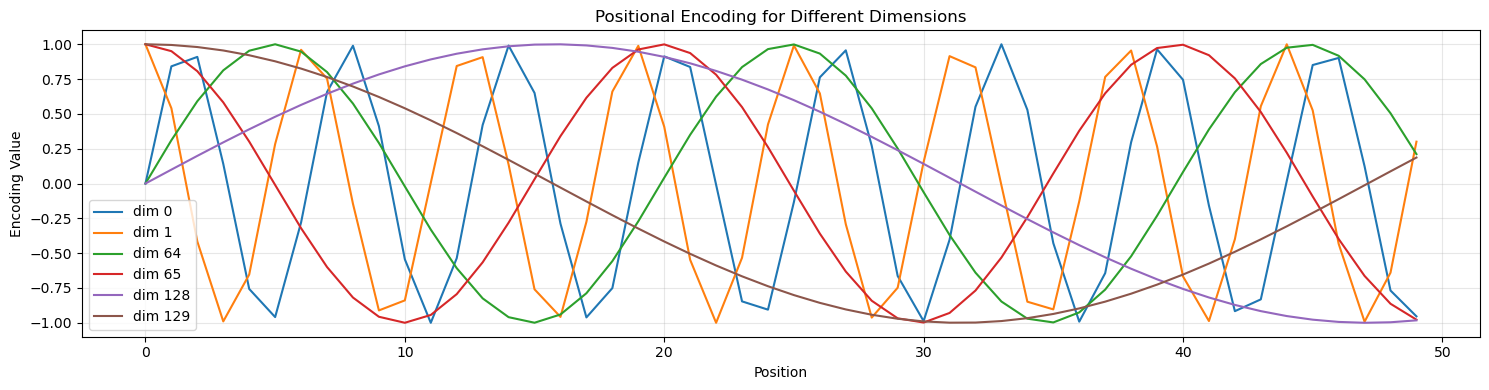

In [7]:
class PositionalEncoding(nn.Module):
    """
    Adds positional information to embeddings using sine and cosine functions.
    
    Args:
        d_model: Dimension of the model
        max_seq_length: Maximum sequence length
        dropout: Dropout probability
    """
    def __init__(self, d_model, max_seq_length=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Create positional encoding matrix
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Add batch dimension
        pe = pe.unsqueeze(0)  # Shape: (1, max_seq_length, d_model)
        
        # Register as buffer (not a parameter, but part of the model state)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # Add positional encoding to input embeddings
        # x shape: (batch_size, seq_length, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# Continue with our example
print("\n" + "=" * 70)
print("CONTINUING WITH: 'transformers process sequences efficiently'")
print("=" * 70)

pos_encoding = PositionalEncoding(d_model, max_seq_length=100)
embedded_with_pos = pos_encoding(embedded_input)

print(f"\n4️⃣ POSITIONAL ENCODING OUTPUT")
print(f"  Input shape (from embeddings): {embedded_input.shape}")
print(f"  Output shape (with positions): {embedded_with_pos.shape}")
print(f"\n  Token '{tokenizer.idx2word[example_token_ids[1]]}' at position 1:")
print(f"  Before positional encoding (first 10 dims): {embedded_input[0, 1, :10].detach().numpy()}")
print(f"  After positional encoding (first 10 dims):  {embedded_with_pos[0, 1, :10].detach().numpy()}")
print(f"\n  ✓ Position information now added to each token's embedding!")

# Visualize positional encodings
plt.figure(figsize=(15, 5))
pe_matrix = pos_encoding.pe[0, :50, :].detach().numpy()
plt.imshow(pe_matrix.T, cmap='RdBu', aspect='auto', vmin=-1, vmax=1)
plt.colorbar()
plt.xlabel('Position')
plt.ylabel('Dimension')
plt.title('Positional Encoding Visualization (50 positions)')
plt.tight_layout()
plt.show()


# Show how different dimensions vary with position
plt.figure(figsize=(15, 4))
for i in [0, 1, 64, 65, 128, 129]:
    plt.plot(pe_matrix[:, i], label=f'dim {i}')
plt.xlabel('Position')
plt.ylabel('Encoding Value')
plt.title('Positional Encoding for Different Dimensions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Multi-Head Attention Mechanism

The core innovation of the Transformer. Attention allows the model to focus on different parts of the input sequence.

**Scaled Dot-Product Attention:**
$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

**Multi-Head Attention:**
- Runs attention mechanism multiple times in parallel (h heads)
- Each head learns different aspects of the relationships
- Outputs are concatenated and linearly transformed

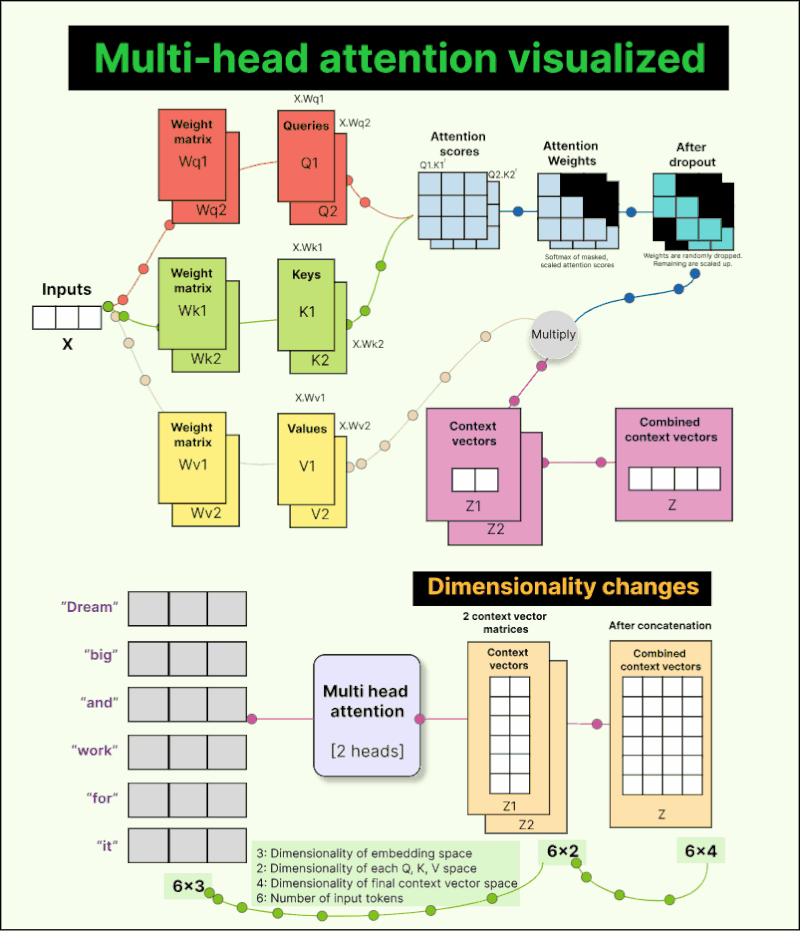

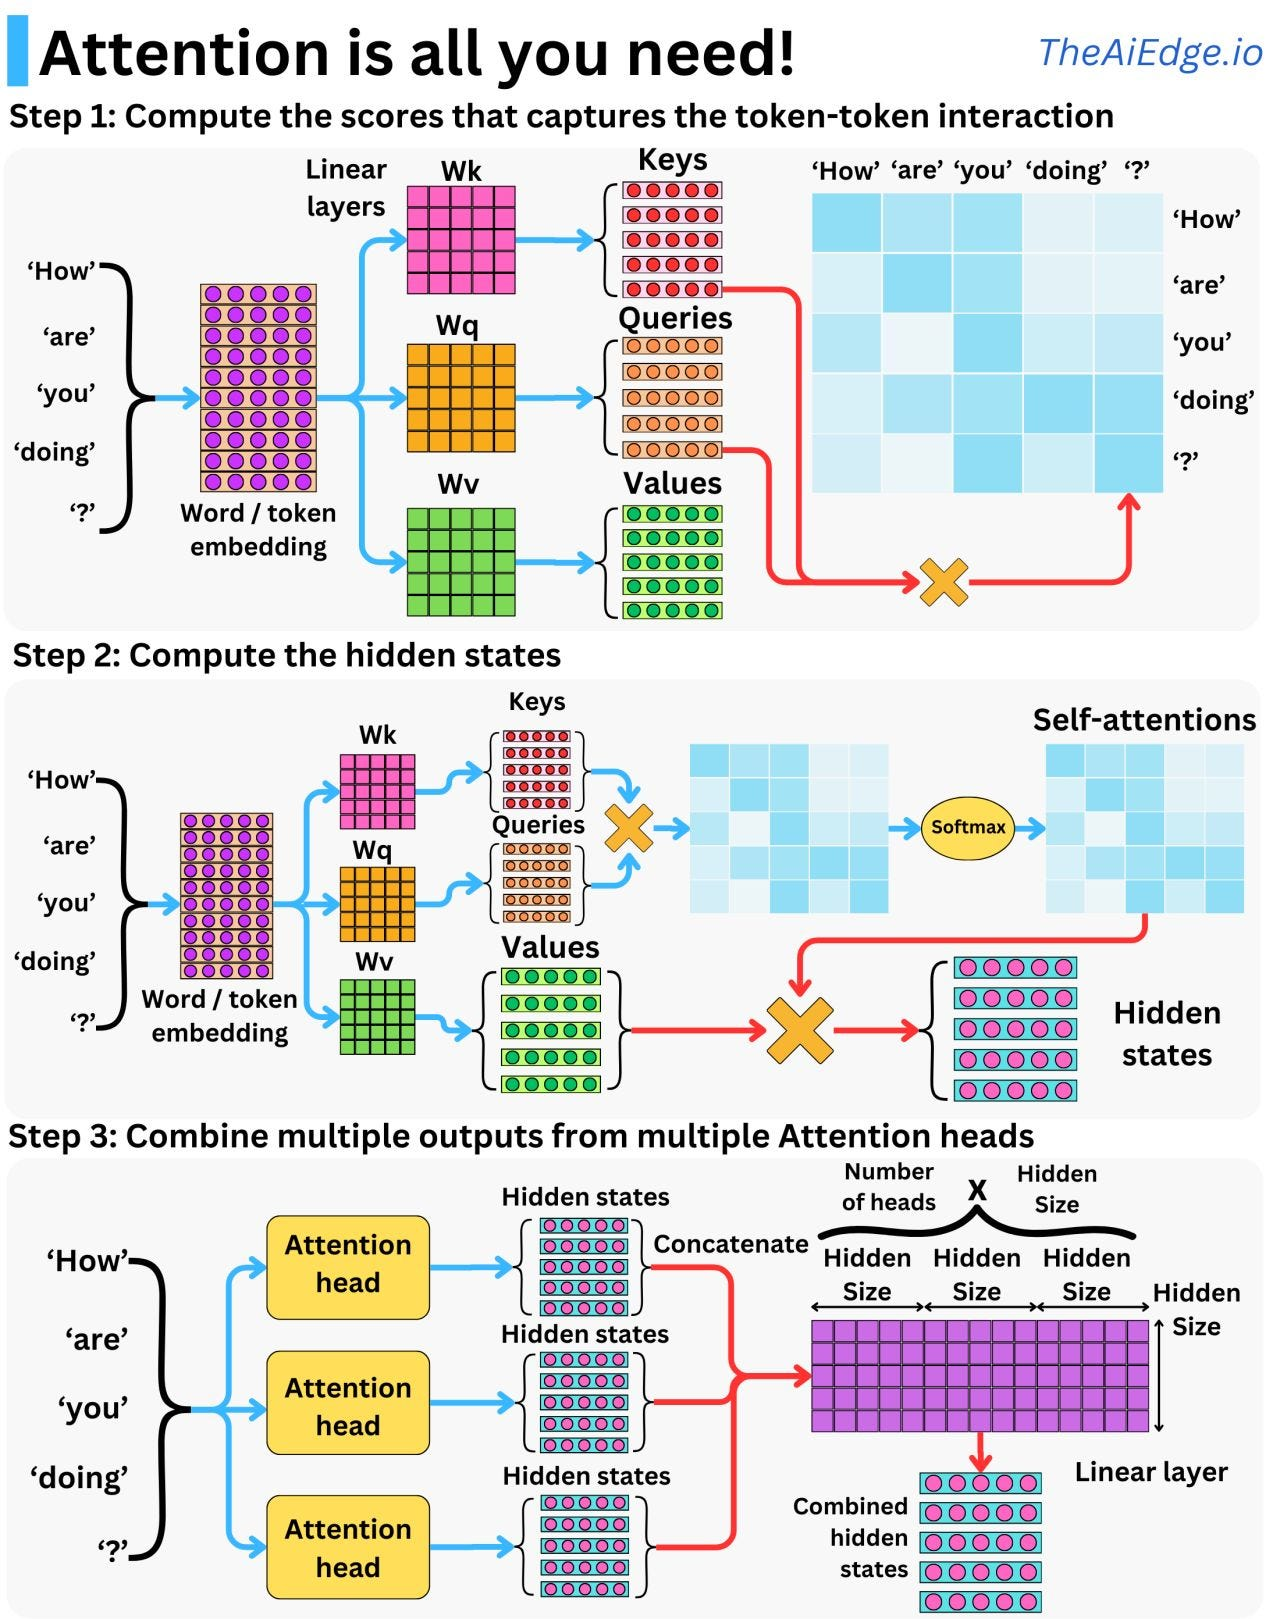

In [8]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention mechanism.
    
    Args:
        d_model: Dimension of the model (embedding size) 
        num_heads: Number of attention heads 
        dropout: Dropout probability
    """
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension of each head #512/8
        
        # Linear projections for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        
        # Output projection
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        Compute scaled dot-product attention.
        
        Args:
            Q: Queries (batch_size, num_heads, seq_length, d_k)
            K: Keys (batch_size, num_heads, seq_length, d_k)
            V: Values (batch_size, num_heads, seq_length, d_k)
            mask: Optional mask (batch_size, 1, seq_length, seq_length)
        """
        # Calculate attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask (if provided)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # Apply softmax
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Multiply by values
        output = torch.matmul(attention_weights, V)
        
        return output, attention_weights
    
    def split_heads(self, x):
        """
        Split the last dimension into (num_heads, d_k).
        Transpose to shape: (batch_size, num_heads, seq_length, d_k)
        """
        batch_size, seq_length, d_model = x.size()
        x = x.view(batch_size, seq_length, self.num_heads, self.d_k)
        return x.transpose(1, 2)
    
    def combine_heads(self, x):
        """
        Inverse of split_heads.
        """
        batch_size, num_heads, seq_length, d_k = x.size()
        x = x.transpose(1, 2).contiguous()
        return x.view(batch_size, seq_length, self.d_model)
    
    def forward(self, query, key, value, mask=None):
        """
        Args:
            query, key, value: Input tensors (batch_size, seq_length, d_model)
            mask: Optional attention mask
        """
        batch_size = query.size(0)
        
        # Linear projections
        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)
        
        # Split into multiple heads
        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)
        
        # Apply attention
        attn_output, attn_weights = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Combine heads
        output = self.combine_heads(attn_output)
        
        # Final linear projection
        output = self.W_o(output)
        
        return output, attn_weights

# Continue with our example
print("\n" + "=" * 70)
print("CONTINUING WITH: 'transformers process sequences efficiently'")
print("=" * 70)

num_heads = 8
mha = MultiHeadAttention(d_model, num_heads)

attn_output, attn_weights = mha(embedded_with_pos, embedded_with_pos, embedded_with_pos)

print(f"\n5️⃣ MULTI-HEAD ATTENTION OUTPUT")
print(f"  Input shape: {embedded_with_pos.shape}")
print(f"  Output shape: {attn_output.shape}")
print(f"  Number of attention heads: {num_heads}")
print(f"  Dimension per head (d_k): {d_model // num_heads}")
print(f"  Attention weights shape: {attn_weights.shape}")
print(f"    └─ (batch_size, num_heads, seq_length, seq_length)")
print(f"\n  Each token can now 'attend' to all other tokens!")
print(f"  Token 1 attention to all positions: {attn_weights[0, 0, 1, :].detach().numpy()}")


CONTINUING WITH: 'transformers process sequences efficiently'

5️⃣ MULTI-HEAD ATTENTION OUTPUT
  Input shape: torch.Size([1, 6, 512])
  Output shape: torch.Size([1, 6, 512])
  Number of attention heads: 8
  Dimension per head (d_k): 64
  Attention weights shape: torch.Size([1, 8, 6, 6])
    └─ (batch_size, num_heads, seq_length, seq_length)

  Each token can now 'attend' to all other tokens!
  Token 1 attention to all positions: [0. 0. 0. 0. 0. 0.]


## 6. Position-wise Feed-Forward Network

After attention, each position passes through a feed-forward network independently.

**Architecture:**
$$\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2$$

- Two linear transformations with ReLU activation in between
- Same network applied to each position separately
- Typical dimension: d_model → d_ff (2048) → d_model

In [9]:
class PositionWiseFeedForward(nn.Module):
    """
    Position-wise Feed-Forward Network.
    
    Args:
        d_model: Dimension of the model
        d_ff: Dimension of the hidden layer
        dropout: Dropout probability
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length, d_model)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Continue with our example
print("\n" + "=" * 70)
print("CONTINUING WITH: 'transformers process sequences efficiently'")
print("=" * 70)

d_ff = 2048

ffn = PositionWiseFeedForward(d_model, d_ff)
ffn_output = ffn(attn_output)

print(f"\n6️⃣ FEED-FORWARD NETWORK OUTPUT")
print(f"  Input shape: {attn_output.shape}")
print(f"  Output shape: {ffn_output.shape}")
print(f"  Hidden layer dimension (d_ff): {d_ff}")
print(f"\n  Transformation: {d_model}D → {d_ff}D → {d_model}D")
print(f"  Applied independently to each token position")


CONTINUING WITH: 'transformers process sequences efficiently'

6️⃣ FEED-FORWARD NETWORK OUTPUT
  Input shape: torch.Size([1, 6, 512])
  Output shape: torch.Size([1, 6, 512])
  Hidden layer dimension (d_ff): 2048

  Transformation: 512D → 2048D → 512D
  Applied independently to each token position


## 7. Layer Normalization and Residual Connections

Each sub-layer (attention and feed-forward) is wrapped with:
1. **Residual Connection**: Adds the input to the output
2. **Layer Normalization**: Normalizes across the feature dimension

**Formula:**
$$\text{LayerNorm}(x + \text{Sublayer}(x))$$

This helps with:
- Training stability
- Gradient flow
- Faster convergence

In [ ]:
class AddNorm(nn.Module):
    """
    Add & Norm layer combining residual connection and layer normalization.
    
    Args:
        d_model: Dimension of the model
        dropout: Dropout probability
    """
    def __init__(self, d_model, dropout=0.1):
        super(AddNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer_output):
        """
        Apply residual connection followed by layer normalization.
        
        Args:
            x: Original input (for residual connection)
            sublayer_output: Output from sublayer (attention or feed-forward)
            
        Returns:
            Normalized output after adding residual connection
        """
        # Add residual connection and normalize
        return self.layer_norm(x + self.dropout(sublayer_output))

In [10]:
# Continue with our example
print("\n" + "=" * 70)
print("CONTINUING WITH: 'transformers process sequences efficiently'")
print("=" * 70)

add_norm = AddNorm(d_model)
normalized_output = add_norm(embedded_with_pos, attn_output)

print(f"\n7️⃣ ADD & NORM OUTPUT")
print(f"  Original input shape: {embedded_with_pos.shape}")
print(f"  Sublayer output shape: {attn_output.shape}")
print(f"  After residual + norm: {normalized_output.shape}")
print(f"\n  Formula: LayerNorm(x + Sublayer(x))")
print(f"  ✓ Residual connection helps gradient flow")
print(f"  ✓ Layer normalization stabilizes training")


CONTINUING WITH: 'transformers process sequences efficiently'


NameError: name 'AddNorm' is not defined

## 8. Encoder Layer

A single encoder layer combines:
1. Multi-head self-attention
2. Add & Norm
3. Feed-forward network
4. Add & Norm

The encoder processes the input sequence and creates rich representations.

In [ ]:
class EncoderLayer(nn.Module):
    """
    Single encoder layer with self-attention and feed-forward network.
    
    Args:
        d_model: Dimension of the model
        num_heads: Number of attention heads
        d_ff: Dimension of feed-forward network
        dropout: Dropout probability
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        
        # Multi-head self-attention
        self.self_attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.add_norm1 = AddNorm(d_model, dropout)
        
        # Feed-forward network
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout)
        self.add_norm2 = AddNorm(d_model, dropout)
        
    def forward(self, x, mask=None):
        """
        Args:
            x: Input tensor (batch_size, seq_length, d_model)
            mask: Optional attention mask
        """
        # Self-attention with residual connection and normalization
        attn_output, _ = self.self_attention(x, x, x, mask)
        x = self.add_norm1(x, attn_output)
        
        # Feed-forward with residual connection and normalization
        ff_output = self.feed_forward(x)
        x = self.add_norm2(x, ff_output)
        
        return x

# Continue with our example
print("\n" + "=" * 70)
print("CONTINUING WITH: 'transformers process sequences efficiently'")
print("=" * 70)

encoder_layer = EncoderLayer(d_model, num_heads, d_ff)
encoder_output = encoder_layer(embedded_with_pos)

print(f"\n8️⃣ ENCODER LAYER OUTPUT")
print(f"  Input shape: {embedded_with_pos.shape}")
print(f"  Output shape: {encoder_output.shape}")
print(f"\n  One encoder layer combines:")
print(f"    1. Multi-Head Self-Attention")
print(f"    2. Add & Norm")
print(f"    3. Feed-Forward Network")
print(f"    4. Add & Norm")
print(f"\n  Our sequence has been processed through one layer!")

## 9. Complete Encoder Stack

The encoder consists of N identical layers stacked together. The original paper uses N=6.

Each layer's output becomes the input to the next layer, allowing the model to build increasingly abstract representations.

In [ ]:
class Encoder(nn.Module):
    """
    Complete Transformer encoder with N layers.
    
    Args:
        vocab_size: Size of the vocabulary
        d_model: Dimension of the model
        num_layers: Number of encoder layers
        num_heads: Number of attention heads
        d_ff: Dimension of feed-forward network
        max_seq_length: Maximum sequence length
        dropout: Dropout probability
    """
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, 
                 max_seq_length, dropout=0.1):
        super(Encoder, self).__init__()
        
        # Embedding and positional encoding
        self.embedding = InputEmbedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_length, dropout)
        
        # Stack of encoder layers
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) 
            for _ in range(num_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        """
        Args:
            x: Input token indices (batch_size, seq_length)
            mask: Optional attention mask
        """
        # Embedding + positional encoding
        x = self.embedding(x)
        x = self.pos_encoding(x)
        
        # Pass through each encoder layer
        for layer in self.layers:
            x = layer(x, mask)
            
        return x

# Continue with our example
print("\n" + "=" * 70)
print("CONTINUING WITH: 'transformers process sequences efficiently'")
print("=" * 70)

num_layers = 6
encoder = Encoder(vocab_size, d_model, num_layers, num_heads, d_ff, 
                  max_seq_length=100, dropout=0.1)
encoder_final_output = encoder(example_tensor)

print(f"\n9️⃣ COMPLETE ENCODER OUTPUT")
print(f"  Number of encoder layers: {num_layers}")
print(f"  Input tokens: {[tokenizer.idx2word[i] for i in example_token_ids]}")
print(f"  Input (token IDs): {example_token_ids}")
print(f"  Output shape: {encoder_final_output.shape}")
print(f"\n  Our text has been encoded into rich {d_model}D representations!")
print(f"  Each token's vector contains contextual information from the entire sequence.")

## 10. Decoder Layer

The decoder is more complex than the encoder. Each decoder layer has:
1. **Masked self-attention** - Prevents positions from attending to future positions
2. **Add & Norm**
3. **Cross-attention** - Attends to encoder output
4. **Add & Norm**
5. **Feed-forward network**
6. **Add & Norm**

The masking ensures the model can only use information from previous positions during training.

In [ ]:
class DecoderLayer(nn.Module):
    """
    Single decoder layer with masked self-attention, cross-attention, and feed-forward.
    
    Args:
        d_model: Dimension of the model
        num_heads: Number of attention heads
        d_ff: Dimension of feed-forward network
        dropout: Dropout probability
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        
        # Masked self-attention
        self.masked_self_attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.add_norm1 = AddNorm(d_model, dropout)
        
        # Cross-attention (attends to encoder output)
        self.cross_attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.add_norm2 = AddNorm(d_model, dropout)
        
        # Feed-forward network
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout)
        self.add_norm3 = AddNorm(d_model, dropout)
        
    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        """
        Args:
            x: Decoder input (batch_size, tgt_seq_length, d_model)
            encoder_output: Output from encoder (batch_size, src_seq_length, d_model)
            src_mask: Mask for encoder output
            tgt_mask: Mask for decoder input (prevents attending to future positions)
        """
        # Masked self-attention
        attn_output, _ = self.masked_self_attention(x, x, x, tgt_mask)
        x = self.add_norm1(x, attn_output)
        
        # Cross-attention to encoder output
        cross_attn_output, _ = self.cross_attention(x, encoder_output, encoder_output, src_mask)
        x = self.add_norm2(x, cross_attn_output)
        
        # Feed-forward
        ff_output = self.feed_forward(x)
        x = self.add_norm3(x, ff_output)
        
        return x

# Continue with our example - create a target sequence
print("\n" + "=" * 70)
print("CONTINUING WITH: 'transformers process sequences efficiently'")
print("=" * 70)

# For decoder demonstration, let's create a simple target sequence
# In practice, this would be the sequence we want to generate
target_text = "les transformateurs traitent des sequences"
target_tokens = tokenizer.encode(target_text, add_special_tokens=True)

target_tensor = torch.tensor([target_tokens])

print(f"\nEncoder processed (English): '{example_text}'")
print(f"Decoder will generate (French): '{target_text}'")
print(f"Target tokens: {[tokenizer.idx2word[i] for i in target_tokens]}")

# Create decoder layer and process
decoder_layer = DecoderLayer(d_model, num_heads, d_ff)
target_embedded = embedding_layer(target_tensor)
target_with_pos = pos_encoding(target_embedded)
decoder_output = decoder_layer(target_with_pos, encoder_final_output)

print(f"\n🔟 DECODER LAYER OUTPUT")
print(f"  Decoder input shape: {target_with_pos.shape}")
print(f"  Encoder output shape: {encoder_final_output.shape}")
print(f"  Decoder output shape: {decoder_output.shape}")
print(f"\n  Decoder layer combines:")
print(f"    1. Masked Self-Attention (on target)")
print(f"    2. Cross-Attention (to encoder output)")
print(f"    3. Feed-Forward Network")


## 11. Complete Decoder Stack

Like the encoder, the decoder consists of N identical layers stacked together.

Each layer processes:
- The target sequence (with masking)
- The encoder's output (via cross-attention)

In [ ]:
class Decoder(nn.Module):
    """
    Complete Transformer decoder with N layers.
    
    Args:
        vocab_size: Size of the vocabulary
        d_model: Dimension of the model
        num_layers: Number of decoder layers
        num_heads: Number of attention heads
        d_ff: Dimension of feed-forward network
        max_seq_length: Maximum sequence length
        dropout: Dropout probability
    """
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, 
                 max_seq_length, dropout=0.1):
        super(Decoder, self).__init__()
        
        # Embedding and positional encoding
        self.embedding = InputEmbedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_length, dropout)
        
        # Stack of decoder layers
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) 
            for _ in range(num_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        """
        Args:
            x: Target token indices (batch_size, tgt_seq_length)
            encoder_output: Output from encoder (batch_size, src_seq_length, d_model)
            src_mask: Mask for encoder output
            tgt_mask: Mask for target sequence
        """
        # Embedding + positional encoding
        x = self.embedding(x)
        x = self.pos_encoding(x)
        
        # Pass through each decoder layer
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
            
        return x

# Continue with our example
print("\n" + "=" * 70)
print("CONTINUING WITH: 'transformers process sequences efficiently'")
print("=" * 70)

decoder = Decoder(vocab_size, d_model, num_layers, num_heads, d_ff, 
                  max_seq_length=100, dropout=0.1)
decoder_final_output = decoder(target_tensor, encoder_final_output)

print(f"\n1️⃣1️⃣ COMPLETE DECODER OUTPUT")
print(f"  Number of decoder layers: {num_layers}")
print(f"  Source (encoder input): '{example_text}'")
print(f"  Target (decoder input): '{target_text}'")
print(f"  Output shape: {decoder_final_output.shape}")
print(f"\n  The decoder has processed the target sequence while")
print(f"  attending to the encoded source sequence!")

## 12. Creating Attention Masks

Two types of masks are needed:

1. **Padding Mask**: Ignores padding tokens in sequences
2. **Causal (Look-ahead) Mask**: Prevents the decoder from seeing future tokens

These masks ensure the model only attends to valid positions.

In [ ]:
def create_padding_mask(seq, pad_token=0):
    """
    Create mask for padding tokens.
    
    Args:
        seq: Input sequence (batch_size, seq_length)
        pad_token: The token ID used for padding
    
    Returns:
        Mask of shape (batch_size, 1, 1, seq_length)
    """
    # Create mask: 1 for real tokens, 0 for padding
    mask = (seq != pad_token).unsqueeze(1).unsqueeze(2)
    return mask

def create_causal_mask(size):
    """
    Create causal (look-ahead) mask for decoder self-attention.
    Prevents positions from attending to future positions.
    
    Args:
        size: Sequence length
    
    Returns:
        Mask of shape (1, 1, size, size)
    """
    # Create lower triangular matrix
    mask = torch.tril(torch.ones(size, size))
    return mask.unsqueeze(0).unsqueeze(0)  # Add batch and head dimensions

# Example usage
seq_len = 5

# Padding mask example
sample_seq_with_padding = torch.tensor([[1, 2, 3, 0, 0], [4, 5, 6, 7, 0]])
padding_mask = create_padding_mask(sample_seq_with_padding)
print("Padding mask shape:", padding_mask.shape)
print("Padding mask for first sequence:\n", padding_mask[0, 0, 0])

# Causal mask example
causal_mask = create_causal_mask(seq_len)
print("\nCausal mask shape:", causal_mask.shape)
print("Causal mask (prevents seeing future):\n", causal_mask[0, 0])

# Visualize causal mask
plt.figure(figsize=(6, 5))
plt.imshow(causal_mask[0, 0].numpy(), cmap='Blues', vmin=0, vmax=1)
plt.colorbar(label='Attention Allowed')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.title('Causal Mask (1 = can attend, 0 = masked)')
plt.tight_layout()
plt.show()

## 13. Complete Transformer Model

Now we combine the encoder and decoder into the complete Transformer architecture for sequence-to-sequence tasks.

In [ ]:
class Transformer(nn.Module):
    """
    Complete Transformer model for sequence-to-sequence tasks.
    
    Args:
        src_vocab_size: Source vocabulary size
        tgt_vocab_size: Target vocabulary size
        d_model: Dimension of the model
        num_layers: Number of encoder/decoder layers
        num_heads: Number of attention heads
        d_ff: Dimension of feed-forward network
        max_seq_length: Maximum sequence length
        dropout: Dropout probability
    """
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, num_layers=6,
                 num_heads=8, d_ff=2048, max_seq_length=5000, dropout=0.1):
        super(Transformer, self).__init__()
        
        # Encoder and Decoder
        self.encoder = Encoder(src_vocab_size, d_model, num_layers, num_heads, 
                               d_ff, max_seq_length, dropout)
        self.decoder = Decoder(tgt_vocab_size, d_model, num_layers, num_heads,
                               d_ff, max_seq_length, dropout)
        
        # Final output projection
        self.output_projection = nn.Linear(d_model, tgt_vocab_size)
        
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        """
        Args:
            src: Source sequence (batch_size, src_seq_length)
            tgt: Target sequence (batch_size, tgt_seq_length)
            src_mask: Mask for source sequence
            tgt_mask: Mask for target sequence
        
        Returns:
            Output logits (batch_size, tgt_seq_length, tgt_vocab_size)
        """
        # Encode source sequence
        encoder_output = self.encoder(src, src_mask)
        
        # Decode to generate target sequence
        decoder_output = self.decoder(tgt, encoder_output, src_mask, tgt_mask)
        
        # Project to vocabulary size
        output = self.output_projection(decoder_output)
        
        return output
    
    def generate(self, src, max_length=50, start_token=1, end_token=2):
        """
        Generate sequence autoregressively (for inference).
        
        Args:
            src: Source sequence (batch_size, src_seq_length)
            max_length: Maximum length to generate
            start_token: Token to start generation
            end_token: Token to end generation
        """
        self.eval()
        batch_size = src.size(0)
        
        # Encode source
        encoder_output = self.encoder(src)
        
        # Start with start token
        tgt = torch.full((batch_size, 1), start_token, dtype=torch.long)
        
        with torch.no_grad():
            for _ in range(max_length - 1):
                # Create causal mask
                tgt_mask = create_causal_mask(tgt.size(1))
                
                # Decode
                decoder_output = self.decoder(tgt, encoder_output, tgt_mask=tgt_mask)
                
                # Get next token prediction
                output = self.output_projection(decoder_output)
                next_token = output[:, -1, :].argmax(dim=-1, keepdim=True)
                
                # Append to target sequence
                tgt = torch.cat([tgt, next_token], dim=1)
                
                # Stop if all sequences generated end token
                if (next_token == end_token).all():
                    break
        
        return tgt

# Create the complete Transformer model
src_vocab_size = 10000
tgt_vocab_size = 10000

transformer = Transformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    d_model=512,
    num_layers=6,
    num_heads=8,
    d_ff=2048,
    max_seq_length=100,
    dropout=0.1
)

# Count parameters
total_params = sum(p.numel() for p in transformer.parameters())
trainable_params = sum(p.numel() for p in transformer.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Test forward pass
src_seq = torch.randint(0, src_vocab_size, (2, 10))
tgt_seq = torch.randint(0, tgt_vocab_size, (2, 8))
tgt_mask = create_causal_mask(8)

output = transformer(src_seq, tgt_seq, tgt_mask=tgt_mask)
print(f"\nInput source shape: {src_seq.shape}")
print(f"Input target shape: {tgt_seq.shape}")
print(f"Output shape: {output.shape}")
print(f"Output represents logits over vocabulary of size {tgt_vocab_size}")

## 14. Training Setup

Now let's set up everything needed for training:
- Loss function (Cross Entropy)
- Optimizer (Adam with learning rate scheduling)
- Training loop

In [ ]:
class NoamLR:
    """
    Learning rate scheduler used in the original Transformer paper.
    
    Formula: lr = d_model^(-0.5) * min(step^(-0.5), step * warmup_steps^(-1.5))
    """
    def __init__(self, optimizer, d_model, warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.step_num = 0
        
    def step(self):
        self.step_num += 1
        lr = self.d_model ** (-0.5) * min(
            self.step_num ** (-0.5),
            self.step_num * self.warmup_steps ** (-1.5)
        )
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        return lr

# Visualize learning rate schedule
d_model = 512
warmup_steps = 4000
steps = np.arange(1, 20000)
learning_rates = []

for step in steps:
    lr = d_model ** (-0.5) * min(step ** (-0.5), step * warmup_steps ** (-1.5))
    learning_rates.append(lr)

plt.figure(figsize=(12, 5))
plt.plot(steps, learning_rates)
plt.xlabel('Training Step')
plt.ylabel('Learning Rate')
plt.title('Noam Learning Rate Schedule')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Peak learning rate: {max(learning_rates):.6f}")
print(f"Learning rate at step {warmup_steps}: {learning_rates[warmup_steps-1]:.6f}")

## 15. Training Loop with Synthetic Data

Let's create a simple training example with synthetic data. For a real application, you would replace this with actual data (e.g., translation pairs).

In [ ]:
def create_synthetic_data(num_samples=1000, src_seq_len=10, tgt_seq_len=10, 
                          src_vocab_size=100, tgt_vocab_size=100):
    """
    Create synthetic data for demonstration.
    In this example: target is source sequence reversed (simple copy task).
    """
    src_data = []
    tgt_data = []
    
    for _ in range(num_samples):
        # Random source sequence (avoiding 0 as it's padding)
        src = torch.randint(1, src_vocab_size, (src_seq_len,))
        # Target is reversed source (with start/end tokens)
        tgt = torch.cat([
            torch.tensor([1]),  # Start token
            torch.flip(src[:tgt_seq_len-2], dims=[0]),
            torch.tensor([2])   # End token
        ])
        src_data.append(src)
        tgt_data.append(tgt)
    
    return torch.stack(src_data), torch.stack(tgt_data)

def train_epoch(model, data_loader, criterion, optimizer, scheduler, device='cpu'):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    
    for batch_idx, (src, tgt) in enumerate(data_loader):
        src, tgt = src.to(device), tgt.to(device)
        
        # Prepare target input and output
        tgt_input = tgt[:, :-1]  # Remove last token for input
        tgt_output = tgt[:, 1:]  # Remove first token for output
        
        # Create masks
        tgt_mask = create_causal_mask(tgt_input.size(1)).to(device)
        
        # Forward pass
        optimizer.zero_grad()
        output = model(src, tgt_input, tgt_mask=tgt_mask)
        
        # Calculate loss
        loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))
        
        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
    
    return total_loss / len(data_loader)

# Create smaller model for demo
small_transformer = Transformer(
    src_vocab_size=100,
    tgt_vocab_size=100,
    d_model=128,
    num_layers=2,
    num_heads=4,
    d_ff=512,
    max_seq_length=50,
    dropout=0.1
)

# Create synthetic dataset
src_data, tgt_data = create_synthetic_data(
    num_samples=500, 
    src_seq_len=10, 
    tgt_seq_len=10,
    src_vocab_size=100,
    tgt_vocab_size=100
)

# Create data loader
from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(src_data, tgt_data)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Setup training
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding
optimizer = torch.optim.Adam(small_transformer.parameters(), betas=(0.9, 0.98), eps=1e-9)
scheduler = NoamLR(optimizer, d_model=128, warmup_steps=400)

# Train for a few epochs
num_epochs = 5
losses = []

print("Training Transformer on synthetic data...")
print("Task: Reverse the input sequence\n")

for epoch in range(num_epochs):
    avg_loss = train_epoch(small_transformer, data_loader, criterion, optimizer, scheduler)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Time')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 16. Testing and Inference

Let's test the trained model on new examples and see how well it learned the reversal task.

In [ ]:
# Test the model
small_transformer.eval()

# Create test samples
test_samples = 5
test_src = torch.randint(1, 100, (test_samples, 10))

print("Testing the Transformer on sequence reversal task:\n")
print("=" * 70)

with torch.no_grad():
    for i in range(test_samples):
        src = test_src[i:i+1]
        
        # Generate prediction
        generated = small_transformer.generate(src, max_length=12, start_token=1, end_token=2)
        
        # Expected output (reversed)
        expected = torch.cat([
            torch.tensor([1]),
            torch.flip(src[0], dims=[0]),
            torch.tensor([2])
        ])
        
        print(f"\nExample {i+1}:")
        print(f"Input:     {src[0].tolist()}")
        print(f"Generated: {generated[0].tolist()}")
        print(f"Expected:  {expected.tolist()}")
        
        # Check if correct (ignoring padding)
        gen_tokens = generated[0, 1:11].tolist()  # Skip start token, get next 10
        exp_tokens = expected[1:11].tolist()
        
        if gen_tokens == exp_tokens:
            print("✓ CORRECT!")
        else:
            print("✗ Incorrect")

print("\n" + "=" * 70)

## 17. Visualizing Attention Weights

One of the most powerful features of Transformers is interpretability through attention weights. Let's visualize what the model is attending to.

In [ ]:
def visualize_attention(model, src, tgt_input, layer_idx=0, head_idx=0):
    """
    Visualize attention weights from a specific layer and head.
    """
    model.eval()
    
    with torch.no_grad():
        # Get encoder output
        src_embedded = model.encoder.embedding(src)
        src_embedded = model.encoder.pos_encoding(src_embedded)
        
        # Pass through encoder layers and capture attention
        x = src_embedded
        for i, layer in enumerate(model.encoder.layers):
            if i == layer_idx:
                # Get attention weights from this layer
                attn_output, attn_weights = layer.self_attention(x, x, x)
                break
            x = layer(x)
        
        # attn_weights shape: (batch_size, num_heads, seq_length, seq_length)
        attention = attn_weights[0, head_idx].cpu().numpy()
        
        return attention

# Take a test example
test_src = torch.randint(1, 100, (1, 10))
test_tgt = torch.randint(1, 100, (1, 10))

# Get attention weights
attention = visualize_attention(small_transformer, test_src, test_tgt, layer_idx=0, head_idx=0)

# Visualize
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for head_idx in range(4):  # Visualize first 4 heads
    attention = visualize_attention(small_transformer, test_src, test_tgt, 
                                     layer_idx=0, head_idx=head_idx)
    
    ax = axes[head_idx]
    im = ax.imshow(attention, cmap='viridis', aspect='auto')
    ax.set_xlabel('Key Position')
    ax.set_ylabel('Query Position')
    ax.set_title(f'Attention Head {head_idx}')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle('Multi-Head Attention Visualization (Layer 0)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Source sequence:", test_src[0].tolist())
print("\nEach heatmap shows how much each query position (rows) attends to key positions (columns)")

## 18. Summary: Key Concepts

### 🎯 Complete Components Built:

**0. Tokenization** - Converting text to numerical tokens (IDs)

**1. Input Embedding** - Maps tokens to continuous vectors, scaled by √d_model

**2. Positional Encoding** - Adds position information using sine/cosine functions

**3. Multi-Head Attention** - Allows model to attend to different representation subspaces
   - Scaled dot-product attention: $\text{Attention}(Q,K,V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$
   - Multiple heads capture different types of relationships

**4. Feed-Forward Network** - Position-wise 2-layer network with ReLU

**5. Residual Connections & Layer Norm** - Stabilizes training and improves gradient flow

**6. Encoder** - Processes input with self-attention (N=6 layers)

**7. Decoder** - Generates output with masked self-attention and cross-attention (N=6 layers)

**8. Complete Transformer** - Combines encoder-decoder for sequence-to-sequence tasks

### 💡 Key Innovations:

- **Parallelization**: Unlike RNNs, all positions processed simultaneously
- **Long-range dependencies**: Direct connections between all positions
- **Interpretability**: Attention weights show what model focuses on
- **No recurrence**: Purely attention-based architecture

### 📊 Architecture Highlights:

- d_model = 512 (embedding dimension)
- num_heads = 8 (attention heads)
- d_ff = 2048 (feed-forward hidden size)
- num_layers = 6 (encoder/decoder depth)
- vocab_size = 30k-50k (typical for subword tokenization)

### 🔄 Complete Data Flow:

```
Raw Text
    ↓
Tokenization (BPE/WordPiece)
    ↓
Token IDs [1, 45, 234, ...]
    ↓
Input Embeddings (512D vectors)
    ↓
+ Positional Encoding
    ↓
Encoder Stack (6 layers)
    ↓
Decoder Stack (6 layers)
    ↓
Output Projection (logits)
    ↓
Softmax → Probabilities
```

This implementation follows the "Attention Is All You Need" paper and can be adapted for various sequence tasks!